# LabChip Analysis

This is some basic, rough, and mostly untested labchip analysis code. See what you can do!

At some point, better versions of this will make their way into the CDK.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import glob
import os
import re
import io

In [9]:
# Read raw data
data_frames = list()
for data_file in glob.glob("../2-data/20250514-labchip/*_Data_*.csv"):
    # print(data_file)
    with open(data_file, "r") as f:
        data_str = f.read()
        match = re.search(r"^DATA$", data_str, re.MULTILINE)
        if match:
            header = data_str[:match.start()].strip()
            data_str = data_str[match.end():]
        else:
            continue

    df = pd.read_csv(io.StringIO(data_str))
    df["File"] = data_file
    
    # Parse Header
    header_dict = dict()
    for line in header.split("\n"):
        if "=" in line:
            key, value = line.split("=")
            df[key] = value
    
    data_frames.append(df)

raw_data = pd.concat(data_frames, axis=0)

raw_data = raw_data[raw_data["File"].str.match(r".*_Data_[A-Za-z0-9]+.csv")]

raw_data["Row"] = raw_data["SampleLabel"].str.extract(r"([A-Za-z]+)").astype(str)
raw_data["Column"] = raw_data["SampleLabel"].str.extract(r"([0-9]+)").astype(int)
raw_data = raw_data.sort_values(by=["Row", "Column"])

# Split out the sample name and dilution data from SampleName
raw_data["Sample"] = raw_data["SampleName"].str.extract(r"([A-Za-z]+)").astype(str)
raw_data["Dilution"] = raw_data["SampleName"].str.extract(r"([0-9]+)").astype(int)

raw_data.head()

,Time,Value,Size,File,VERSION,ExportFileName,SampleLabel,SampleName,SampleComment,SampleAreaConcRatio,...,PlateDataEndTime,PlateConcUnits,PlateSizeUnits,PlateLadderSizes,ChipID,Operator,Row,Column,Sample,Dilution
0,0.000,47.075,0.0,../2-data/20250514-labchip/Factor Mix 1_2025-0...,1.3,Factor Mix 1_2025-05-14_13-24-16_labchip_PURE_...,A1,Factor Mix 1,,0.010517,...,42.00,ng/ul,kDa,"1.40,15.90,20.40,28.90,48.40,68.40,119.20",H296P-0563N-03,ACJS,A,1,Factor,1
1,0.017,47.153,0.0,../2-data/20250514-labchip/Factor Mix 1_2025-0...,1.3,Factor Mix 1_2025-05-14_13-24-16_labchip_PURE_...,A1,Factor Mix 1,,0.010517,...,42.00,ng/ul,kDa,"1.40,15.90,20.40,28.90,48.40,68.40,119.20",H296P-0563N-03,ACJS,A,1,Factor,1
2,0.033,47.198,0.0,../2-data/20250514-labchip/Factor Mix 1_2025-0...,1.3,Factor Mix 1_2025-05-14_13-24-16_labchip_PURE_...,A1,Factor Mix 1,,0.010517,...,42.00,ng/ul,kDa,"1.40,15.90,20.40,28.90,48.40,68.40,119.20",H296P-0563N-03,ACJS,A,1,Factor,1
3,0.050,47.171,0.0,../2-data/20250514-labchip/Factor Mix 1_2025-0...,1.3,Factor Mix 1_2025-05-14_13-24-16_labchip_PURE_...,A1,Factor Mix 1,,0.010517,...,42.00,ng/ul,kDa,"1.40,15.90,20.40,28.90,48.40,68.40,119.20",H296P-0563N-03,ACJS,A,1,Factor,1
4,0.067,47.119,0.0,../2-data/20250514-labchip/Factor Mix 1_2025-0...,1.3,Factor Mix 1_2025-05-14_13-24-16_labchip_PURE_...,A1,Factor Mix 1,,0.010517,...,42.00,ng/ul,kDa,"1.40,15.90,20.40,28.90,48.40,68.40,119.20",H296P-0563N-03,ACJS,A,1,Factor,1


# Plot the raw traces.

The OnePot protein samples are arranged across the columns (1--12). Dilutions (as prepared for Pierce600) are arrayed down the rows. Note that we didn't concentration-normalize the samples; the same dilution for two different samples may be at different levels.

Also note that the linear range for the Labchip is below 2 mg/mL, so the early (lower) dilutions are too high for accurate quantitation.

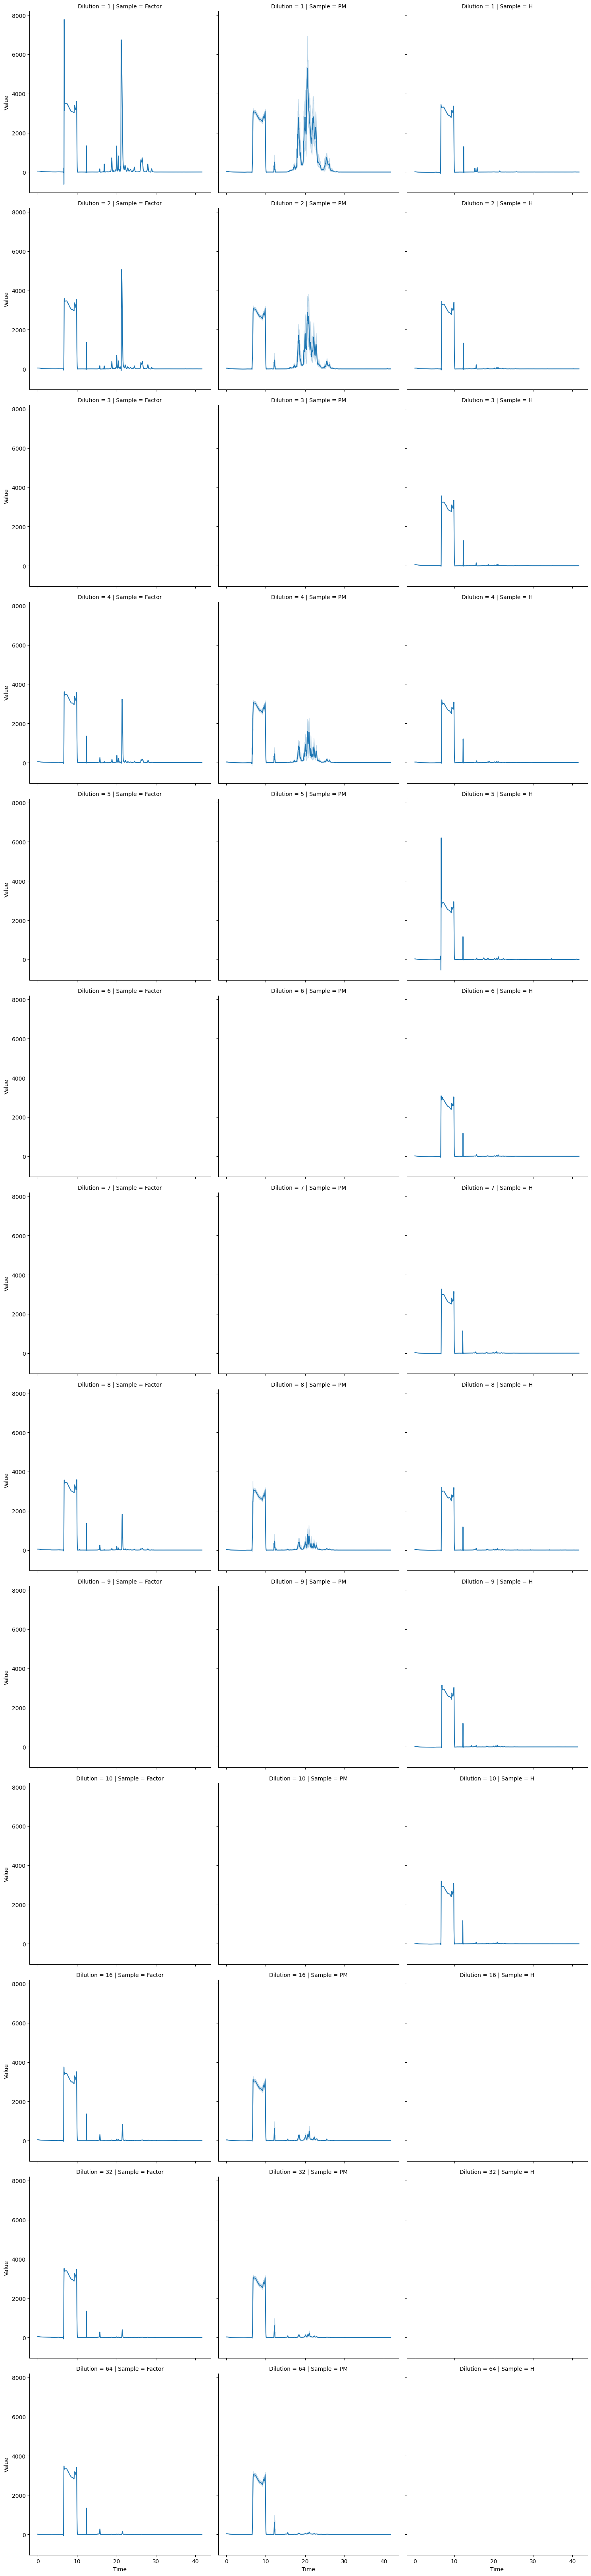

In [12]:
sns.relplot(
    data=raw_data,
    x="Time",
    y="Value",
    row="Dilution",
    col="Sample",
    kind="line"
)

Overlay all the samples at a single dilution (in this case, 4).

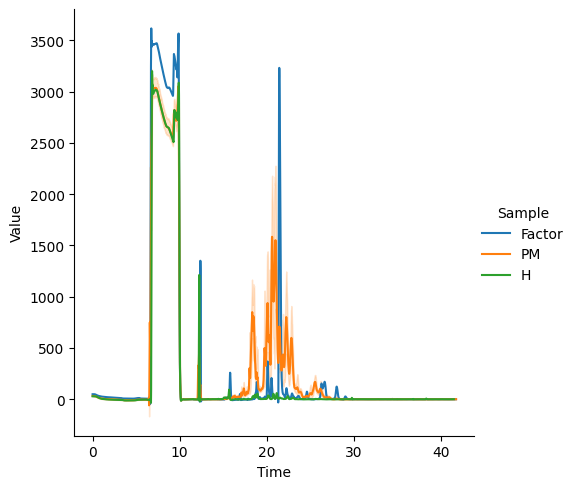

In [13]:
sns.relplot(
    data=raw_data[raw_data["Dilution"] == 4],
    x="Time",
    y="Value",
    hue="Sample",
    kind="line"
)